# Importing Libraries

In [1]:
# Importing Libraries for ML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import ttest_ind

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import yeojohnson

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import FunctionTransformer, PowerTransformer

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

# Importing Cleaned Data

In [2]:
df = pd.read_csv('cleaned_data.csv')
df.head(3)

,Age,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Sex_Male,Heart Disease_Presence
0,70.0,4.0,130.0,322.000000,0.0,3.0,109.0,0.0,2.4,2.0,3.0,3.0,1.0,1.0
1,67.0,3.0,115.0,404.850081,0.0,3.0,160.0,0.0,1.6,2.0,0.0,7.0,0.0,0.0
2,57.0,2.0,124.0,261.000000,0.0,1.0,141.0,0.0,0.3,1.0,0.0,7.0,1.0,1.0


# 1. Feature Selection

## Selecting the features based upon mutual information gain in classification

In [3]:
# splitting the dataset into dependant and independant variables
x = df.drop('Heart Disease_Presence', axis=1)
y = df['Heart Disease_Presence']

In [5]:
# Function for selecting the features based upon mutual information gain in classification
# Values ranges from 0-1 higher is better and that variable selected

def select_features_mutual_info_classification(features, target, threashold):
    mutual_info = mutual_info_classif(features, target)
    mutual_data = pd.Series(mutual_info,index = features.columns)
    top_feature = mutual_data.sort_values(ascending=False)
    return top_feature[top_feature>threashold] 

top_features = select_features_mutual_info_classification(x, y, 0.01)
top_features

Thallium                   0.171653
Chest pain type            0.137474
Number of vessels fluro    0.128231
Exercise angina            0.121522
ST depression              0.109769
Cholesterol                0.084306
Slope of ST                0.082801
Max HR                     0.069459
Sex_Male                   0.064173
EKG results                0.036641
BP                         0.021030
dtype: float64

In [15]:
# Select K best with chi2 test

x = df.iloc[:, :-1]
y = df["Heart Disease_Presence"]

select_feature = SelectKBest(score_func = chi2, k=5)
features = select_feature.fit(x, y)

features_df = pd.DataFrame(x.columns, columns=["Features"])
scores_df = pd.DataFrame(features.scores_, columns=["Scores"])

feature_scores_df = pd.concat([features_df, scores_df], axis=1)
feature_scores_df.sort_values(by="Scores", ascending=False)

,Features,Scores
6,Max HR,163.614084
10,Number of vessels fluro,74.129315
11,Thallium,60.490640
8,ST depression,55.967845
3,Cholesterol,48.172307
7,Exercise angina,31.146473
0,Age,19.161032
2,BP,17.603855
1,Chest pain type,13.174170
12,Sex_Male,7.199755


In [21]:
# select features based on k select 
df_feature_selected = df[list(feature_scores_df['Features'])]
df_feature_selected['Heart Disease_Presence'] = df['Heart Disease_Presence'] 
df_feature_selected.head()

,Age,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Sex_Male,Heart Disease_Presence
0,70.0,4.0,130.0,322.000000,0.0,3.0,109.0,0.0,2.4,2.0,3.0,3.0,1.0,1.0
1,67.0,3.0,115.0,404.850081,0.0,3.0,160.0,0.0,1.6,2.0,0.0,7.0,0.0,0.0
2,57.0,2.0,124.0,261.000000,0.0,1.0,141.0,0.0,0.3,1.0,0.0,7.0,1.0,1.0
3,64.0,4.0,128.0,263.000000,0.0,1.0,105.0,1.0,0.2,2.0,1.0,7.0,1.0,0.0
4,74.0,2.0,120.0,269.000000,0.0,3.0,121.0,1.0,0.2,1.0,1.0,3.0,0.0,0.0


## Conclusion - 
- We have used the Select K Best algorithm to select the variables with chi2 test
- We have used mutual information gain algorithm to select best variables

# 2. Imbalanced Data

(119, 14) (150, 14)


<Axes: >

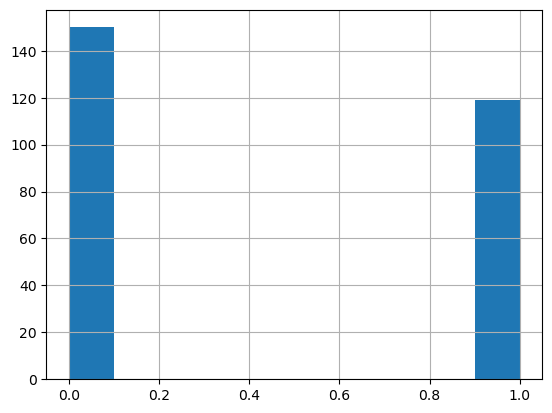

In [22]:
# lets plot the status column values to see the imbalance in the dataset
positive = df_feature_selected[df_feature_selected["Heart Disease_Presence"]==1]
negative = df_feature_selected[df_feature_selected["Heart Disease_Presence"]==0]

# shape of the data
print(positive.shape, negative.shape)

# plot the count of records for status 1 and 0
df_feature_selected["Heart Disease_Presence"].hist()

### From above we can conclude that data is imbalanced.
As we can see dataset having 150 records for postive while only 119 records for negative outcomes. Hence we will upsample the dataset for negative outcomes

### Upsampling -

- We don't reduce the dataset from class having maximum instances but we rather increase the instances of class who have less dataset.

In [24]:
x = df_feature_selected.drop(["Heart Disease_Presence"], axis=1)
y = df_feature_selected["Heart Disease_Presence"]

print(x.shape, y.shape)

over_sampler = RandomOverSampler()
X_res, Y_res = over_sampler.fit_resample(x, y)


# Combining the datasets after upsampling
df_upsample = X_res
df_upsample['Heart Disease_Presence'] = Y_res
df_upsample.head()

(269, 13) (269,)


,Age,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Sex_Male,Heart Disease_Presence
0,70.0,4.0,130.0,322.000000,0.0,3.0,109.0,0.0,2.4,2.0,3.0,3.0,1.0,1.0
1,67.0,3.0,115.0,404.850081,0.0,3.0,160.0,0.0,1.6,2.0,0.0,7.0,0.0,0.0
2,57.0,2.0,124.0,261.000000,0.0,1.0,141.0,0.0,0.3,1.0,0.0,7.0,1.0,1.0
3,64.0,4.0,128.0,263.000000,0.0,1.0,105.0,1.0,0.2,2.0,1.0,7.0,1.0,0.0
4,74.0,2.0,120.0,269.000000,0.0,3.0,121.0,1.0,0.2,1.0,1.0,3.0,0.0,0.0


(150, 14) (150, 14)


<Axes: >

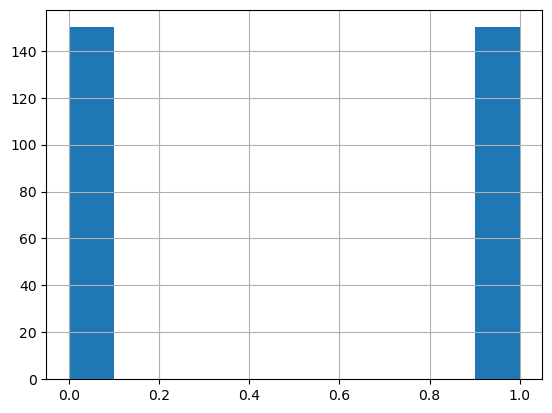

In [27]:
# lets plot the status column values to see the imbalance in the dataset
positive = df_upsample[df_upsample["Heart Disease_Presence"]==1]
negative = df_upsample[df_upsample["Heart Disease_Presence"]==0]

# shape of the data
print(positive.shape, negative.shape)

# plot the count of records for status 1 and 0
df_upsample["Heart Disease_Presence"].hist()

# 3. Feature Transformation

In [28]:
df_upsample.head()

,Age,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Sex_Male,Heart Disease_Presence
0,70.0,4.0,130.0,322.000000,0.0,3.0,109.0,0.0,2.4,2.0,3.0,3.0,1.0,1.0
1,67.0,3.0,115.0,404.850081,0.0,3.0,160.0,0.0,1.6,2.0,0.0,7.0,0.0,0.0
2,57.0,2.0,124.0,261.000000,0.0,1.0,141.0,0.0,0.3,1.0,0.0,7.0,1.0,1.0
3,64.0,4.0,128.0,263.000000,0.0,1.0,105.0,1.0,0.2,2.0,1.0,7.0,1.0,0.0
4,74.0,2.0,120.0,269.000000,0.0,3.0,121.0,1.0,0.2,1.0,1.0,3.0,0.0,0.0


In [29]:
# Function to create dataframe for columns and its unique count of values, datatypes and type of columns
def find_categorical_continous_variables(data, threashold):
    dic = {}
    continus_cols = []
    categorical_cols = []

    for column in data.columns:
        li = []
        li.append(len(data[column].unique()))
        li.append(data[column].dtype)

        # Check if the column is categorical or continuous
        if len(data[column].unique()) <= threashold or data[column].dtype == 'O':
            li.append("Categorical column")
            categorical_cols.append(column)
        else:
            li.append("Continous Column")
            continus_cols.append(column)

        dic[column] = li
    
    # create dataframe for columns and its details
    dic_df = pd.DataFrame(dic, index=["Unique values", "Data Type", "Categorical/Continous"])
    
    # return the dataframe, and lists for continous and categorical columns
    return dic_df.T, categorical_cols, continus_cols

# Function to find descriptive statistics by providing it the contious cols and dataframe
def descriptive_statistics_continous(df, continus_cols):
    dic={}
    for col in continus_cols:
        dic[col] = []
        dic[col].append(df[col].mean())
        dic[col].append(df[col].median())
        dic[col].append(df[col].mode()[0])
        dic[col].append(df[col].std())
        dic[col].append(df[col].var())
        dic[col].append(df[col].max() - df[col].min())
        dic[col].append(df[col].quantile(0.75) - df[col].quantile(0.25) )
        dic[col].append(df[col].skew())
        dic[col].append(df[col].kurtosis())

    df_details = pd.DataFrame(dic, index=["Mean", "Median", "Mode", "Std Deviation", "Variance", "Range", "IQR", "Skew", "Kurtosis"])
    df_details = df_details.T
    
    # find out the skenewss
    df_details.loc[df_details["Skew"]<=-0.5, "Skeness"] = "Left/Negative Skew"
    df_details.loc[df_details["Skew"]>=0.5, "Skeness"] = "Right/Positive Skew"
    df_details.loc[(df_details["Skew"]<0.5) & (df_details["Skew"]>-0.5), "Skeness"] = "Symmetric"
    
    # find out the kurtosis
    df_details.loc[df_details["Kurtosis"]<2.5, "Kurtosis_type"] = "Platykurtic"
    df_details.loc[df_details["Kurtosis"]>3.5, "Kurtosis_type"] = "Leptokurtic"
    df_details.loc[(df_details["Kurtosis"]<3.5) & (df_details["Kurtosis"]>2.5), "Kurtosis_type"] = "Mesokurtic"
    
    return df_details

# lets find out the unique counts, datatypes, variable type like continous/categorical and lists for columns names having continous/categorical columns
col_type_df, categorical_cols, continus_cols = find_categorical_continous_variables(df_upsample, 10)

# Get the descriptive statistics
df_distribution = descriptive_statistics_continous(df_upsample, continus_cols)
df_distribution

,Mean,Median,Mode,Std Deviation,Variance,Range,IQR,Skew,Kurtosis,Skeness,Kurtosis_type
Age,54.930000,56.0,58.0,8.968829,80.439900,48.000000,13.25,-0.244442,-0.501847,Symmetric,Platykurtic
BP,131.693838,130.0,120.0,17.574243,308.854006,90.771569,20.00,0.650002,0.558350,Right/Positive Skew,Platykurtic
Cholesterol,250.223004,246.0,254.0,48.814797,2382.884415,278.850081,68.25,0.545410,0.644268,Right/Positive Skew,Platykurtic
Max HR,148.219414,152.0,132.0,23.687400,561.092929,121.587827,33.00,-0.477476,-0.293297,Symmetric,Platykurtic
ST depression,1.093333,0.9,0.0,1.121553,1.257882,4.000000,1.80,0.927374,0.052046,Right/Positive Skew,Platykurtic


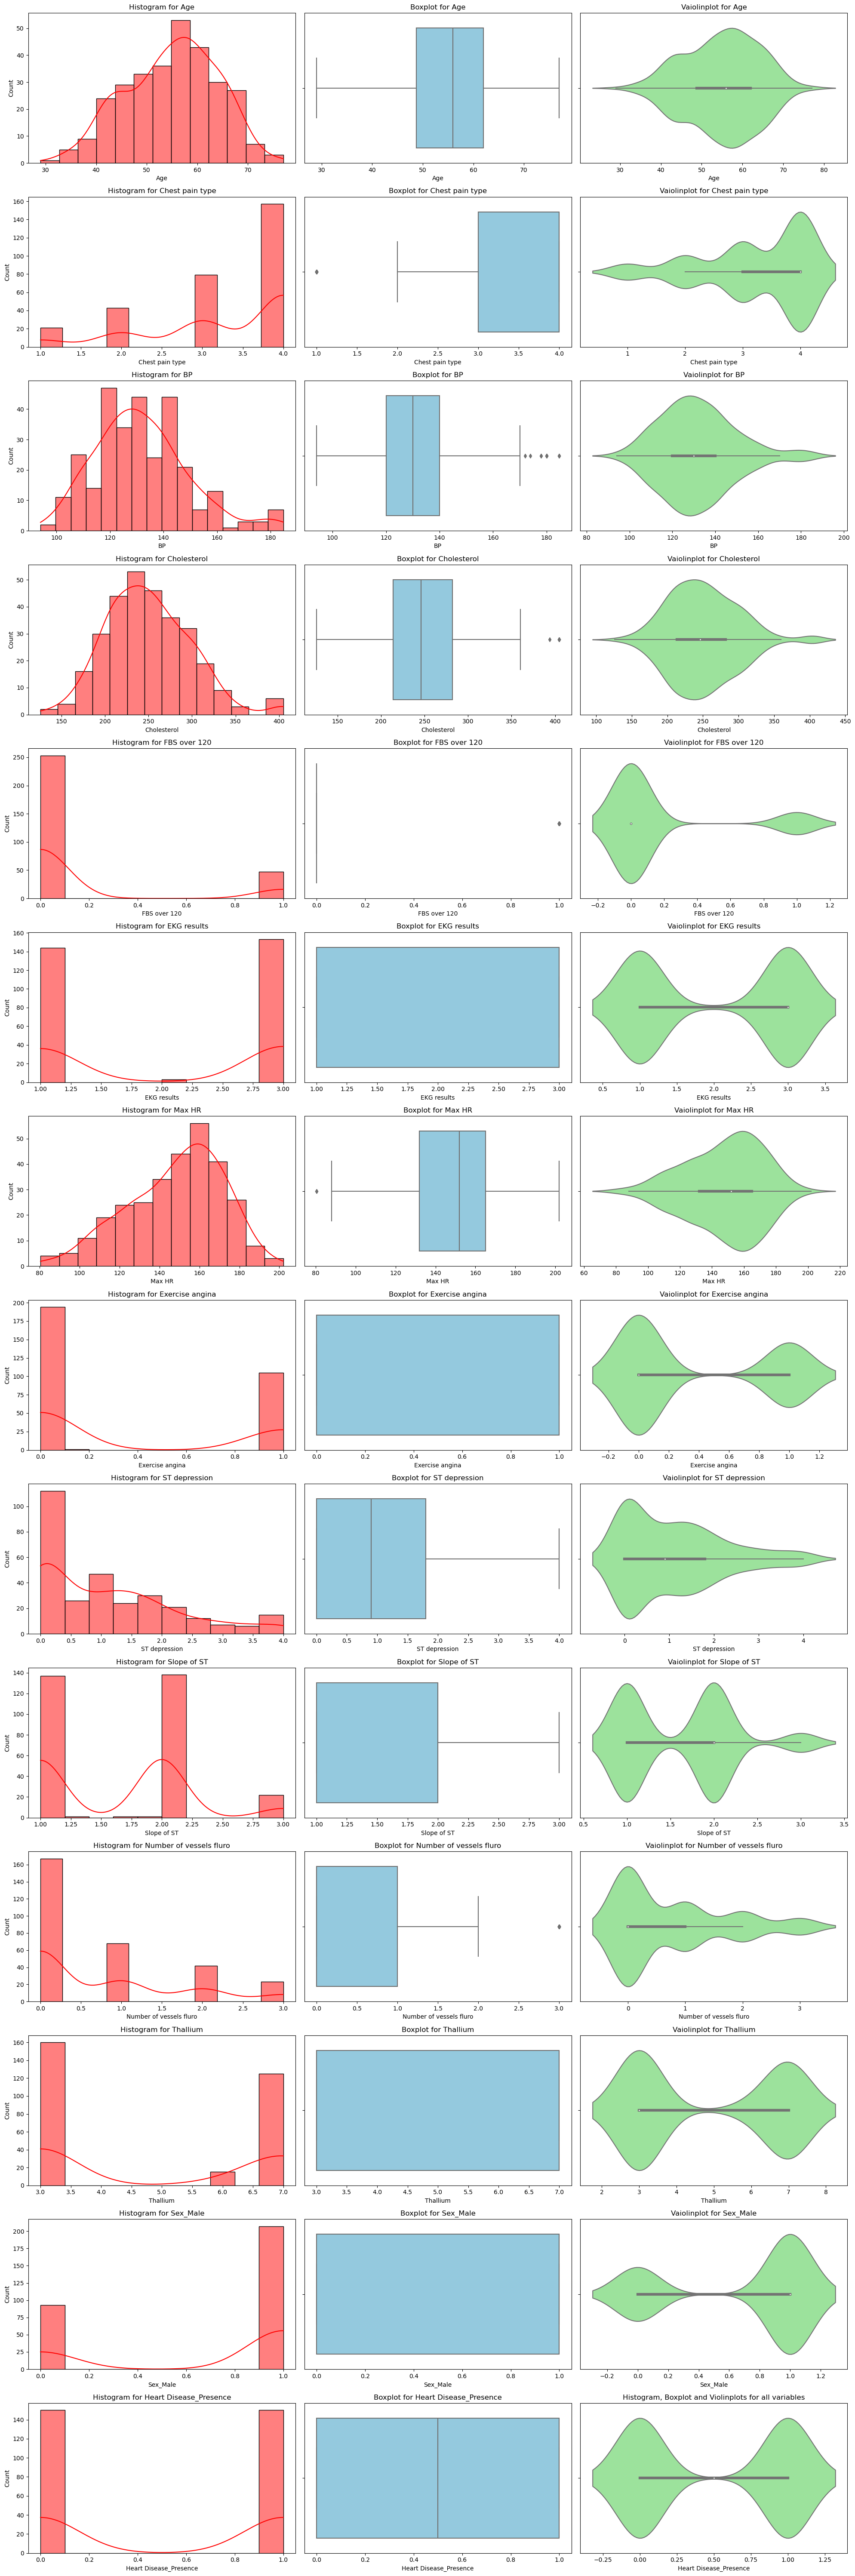

In [30]:
def plot_distribution_numerical(df):

    # Lets plot the histogram for each variable
    features = df.select_dtypes(include='number').columns

    # plot the subplot for histogram of each variable
    fig, axs = plt.subplots(len(df.columns), 3, figsize=(20, 60))
    row = 0
    for feature in features:

        axs[row, 0].set_title("Histogram for {}".format(feature))
        sns.histplot(data=df, x=feature, kde=True, color="red", ax=axs[row, 0])

        axs[row, 1].set_title("Boxplot for {}".format(feature))
        sns.boxplot(data=df, x=feature,  color="skyblue", ax=axs[row, 1])

        axs[row, 2].set_title("Vaiolinplot for {}".format(feature))
        sns.violinplot(data=df, x=feature,  color="lightgreen", ax=axs[row, 2])
        row = row+1

    plt.title("Histogram, Boxplot and Violinplots for all variables")
    plt.tight_layout()
    plt.show()
    
plot_distribution_numerical(df_upsample)

In [31]:
right_skewed_columns = [df_distribution["Skeness"]=='Right/Positive Skew'].index
print(right_skewed_columns)

<built-in method index of list object at 0x00000260C41551C0>


In [32]:
normal_distributed_columns = df_distribution[df_distribution["Skeness"]=='Symmetric'].index
print(normal_distributed_columns)

Index(['Age', 'Max HR'], dtype='object')


In [33]:
left_skewed_columns= df_distribution[df_distribution["Skeness"]=='Left/Negative Skew'].index
print(left_skewed_columns)

Index([], dtype='object')


In [34]:
# Function to find out which feature transformation method for which column
def select_feature_transformation_methods(X):

    # Initialize dictionary to store selected transformation methods for each column
    transformation_methods = {}
    df_transformed = pd.DataFrame()

    # Loop through each column of the dataset
    for col_name in X.columns:
        column_data = X[col_name].to_numpy()  # Convert Pandas Series to NumPy array

        # Check if column contains only positive values and a wide range
        if np.all(column_data > 0) and (np.max(column_data) - np.min(column_data)) > 10:
            transformation_methods[col_name] = 'logarithmic'
            df_transformed[col_name] = np.log1p(column_data)

        # Check if column has large values and heavy tails
        elif np.max(column_data) > 100 and np.ptp(column_data) > 100:
            transformation_methods[col_name] = 'square'
            df_transformed[col_name] = np.square(column_data)

        # Check if column has small values and heavy tails
        elif np.max(column_data) < 10 and np.ptp(column_data) > 10:
            transformation_methods[col_name] = 'reciprocal'
            df_transformed[col_name] = np.reciprocal(column_data)

        # For other cases, use Box-Cox or Yeo-Johnson transformation
        else:
            try:
                _ , maxlog, _ = yeojohnson(column_data)
                if maxlog < 0:
                    transformation_methods[col_name] = 'yeo_johnson'
                    transformer = PowerTransformer(method='yeo-johnson')
                    df_transformed[col_name] = transformer.fit_transform(column_data.reshape(-1, 1)).flatten()

                else:
                    transformation_methods[col_name] = 'boxcox'
                    transformer = PowerTransformer(method='box-cox')
                    df_transformed[col_name] = transformer.fit_transform(column_data.reshape(-1, 1)).flatten()

            except ValueError:
                transformation_methods[col_name] = 'square'
                df_transformed[col_name] = np.square(column_data)
                
    return transformation_methods, df_transformed

transformation_methods, df_transformed = select_feature_transformation_methods(df_upsample)

In [35]:
transformation_methods

{'Age': 'logarithmic',
 'Chest pain type': 'square',
 'BP': 'logarithmic',
 'Cholesterol': 'logarithmic',
 'FBS over 120': 'square',
 'EKG results': 'square',
 'Max HR': 'logarithmic',
 'Exercise angina': 'square',
 'ST depression': 'square',
 'Slope of ST': 'square',
 'Number of vessels fluro': 'square',
 'Thallium': 'square',
 'Sex_Male': 'square',
 'Heart Disease_Presence': 'square'}

In [36]:
df_transformed.head()

,Age,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Sex_Male,Heart Disease_Presence
0,4.262680,16.0,4.875197,5.777652,0.0,9.0,4.700480,0.0,5.76,4.0,9.0,9.0,1.0,1.0
1,4.219508,9.0,4.753590,6.005984,0.0,9.0,5.081404,0.0,2.56,4.0,0.0,49.0,0.0,0.0
2,4.060443,4.0,4.828314,5.568345,0.0,1.0,4.955827,0.0,0.09,1.0,0.0,49.0,1.0,1.0
3,4.174387,16.0,4.859812,5.575949,0.0,1.0,4.663439,1.0,0.04,4.0,1.0,49.0,1.0,0.0
4,4.317488,4.0,4.795791,5.598422,0.0,9.0,4.804021,1.0,0.04,1.0,1.0,9.0,0.0,0.0


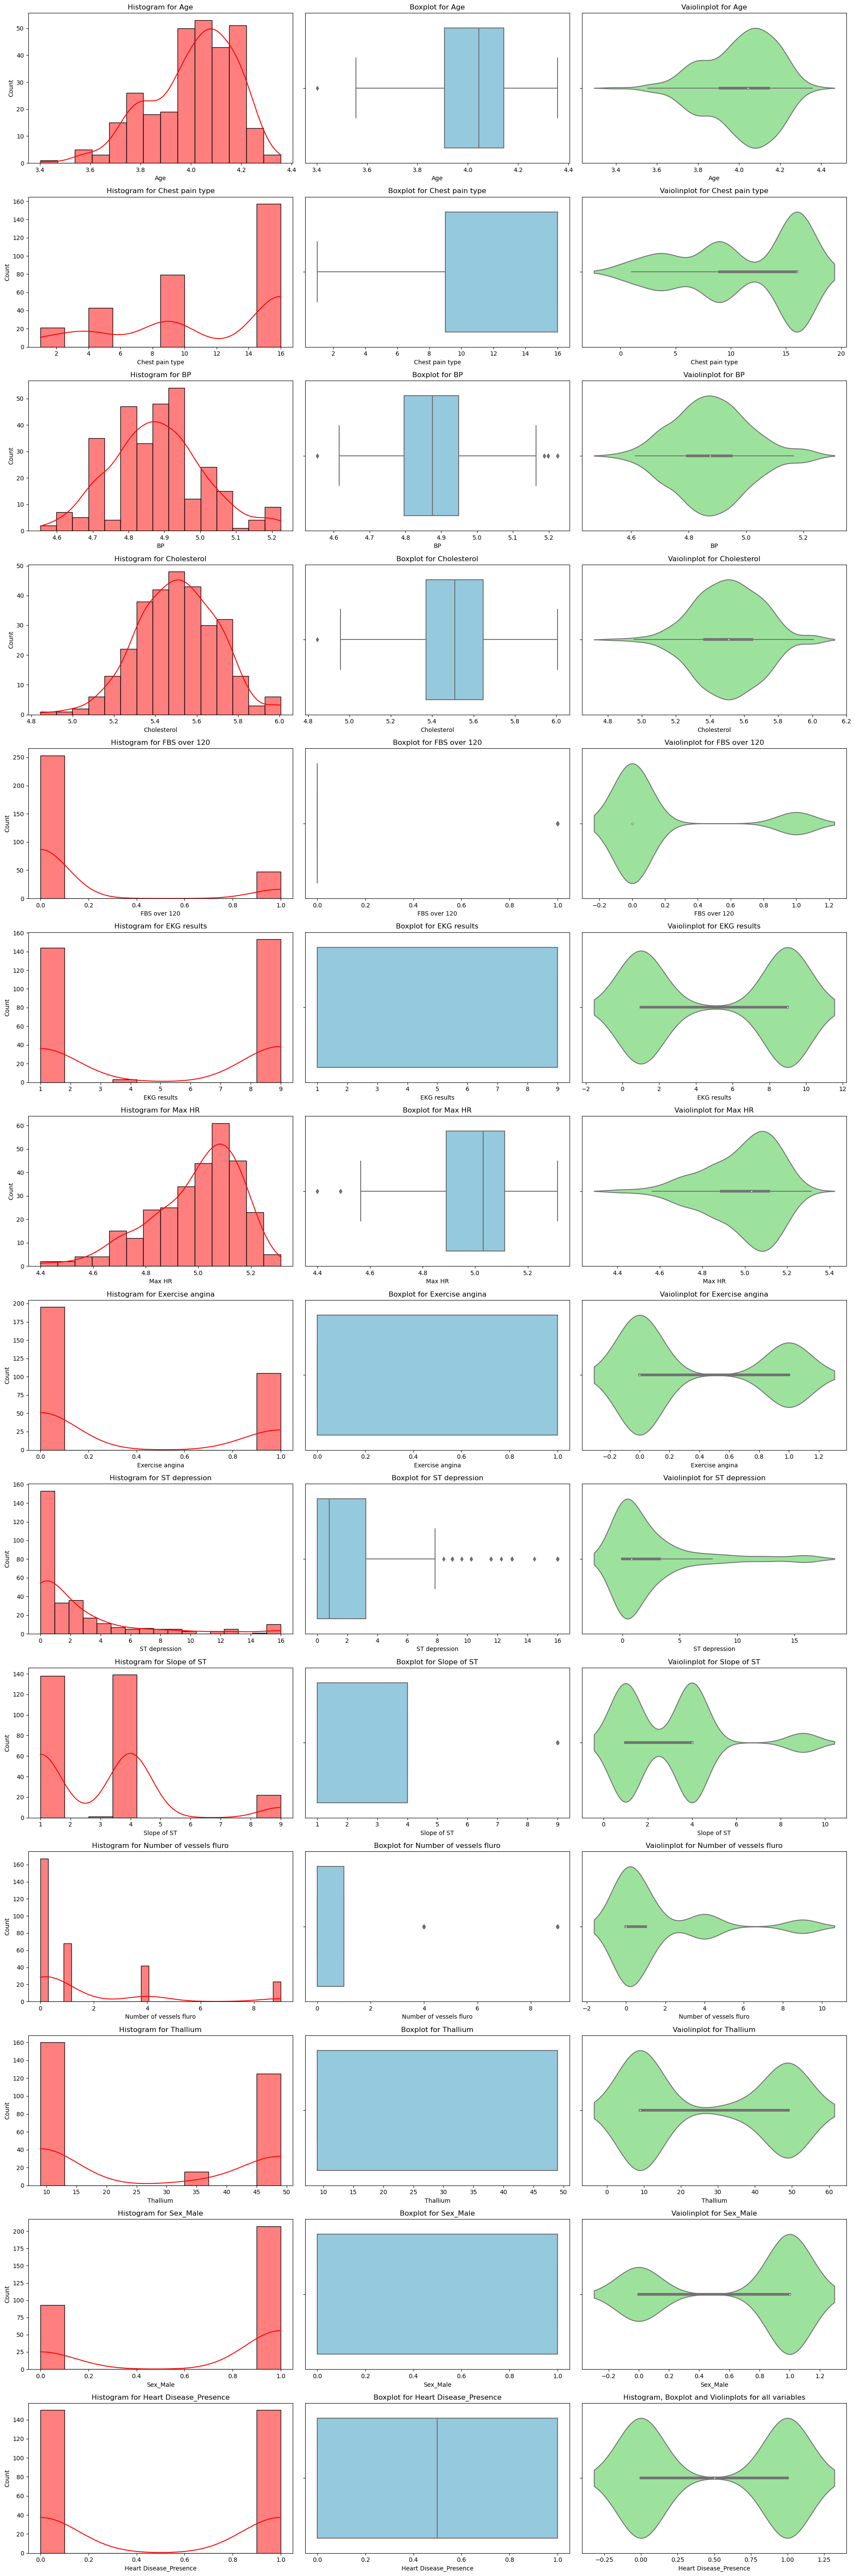

In [37]:
plot_distribution_numerical(df_transformed)

## Saving the Data

In [38]:
df_transformed.to_csv('feature_transformed_data.csv', index=False)

In [39]:
pd.DataFrame(transformation_methods, index=["Type of Feature Transformation"]).T.to_csv('feature_transformation_methods.csv', index=False)